In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

In [2]:
class Morphology(object):

    def __init__(self, img):
        # 画像をグレースケールに変換
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 判別分析法により2値化
        self.img = binarize(img)
        self.len_ver = len(img)
        self.len_hor = len(img[0])
        self.on = self.img

    # オープニング
    def open(self, iteration=1):
        self.opening = erode(self.img, iteration)
        self.opening = dilate(self.opening, iteration)
        self.on = self.opening

    # クロージング
    def close(self, iteration=1):
        self.closing = dilate(self.img, iteration)
        self.closing = erode(self.closing, iteration)
        self.on = self.closing

    # 画像を表示する
    def view(self):
        plt.imshow(self.on)

    # 画像を保存する
    def save(self, img_name):
        cv2.imwrite(img_name, self.on)

    # 重心を求める
    def center(self):
        # モーメント
        m_0 = m_x = m_y = 0
        for i in range(self.len_ver):
            for j in range(self.len_hor):
                if self.on[i][j] == 0:
                    m_0 += 1
                    m_x += i
                    m_y += j

        m_x /= m_0
        m_y /= m_0
        
        # 重心の座標
        self.cg = [m_x, m_y]

    # 外接長方形を求める
    def rect(self):
        x_min = x_max = y_min = y_max = 0

        for i in range(self.len_ver):
            if np.sum(self.on[i]) != 255*self.len_hor:
                y_min = i
                break

        for i in range(1, self.len_ver+1):
            if np.sum(self.on[-i]) != 255*self.len_hor:
                y_max = self.len_ver - i
                break

        for i in range(self.len_hor):
            if np.sum(self.on[:, i]) != 255*self.len_ver:
                x_min = i
                break

        for i in range(1, self.len_hor+1):
            if np.sum(self.on[:, -i]) != 255*self.len_ver:
                x_max = self.len_hor - i
                break

        # 外接長方形の座標の最小値、最大値
        self.rectangle = [x_min, x_max, y_min, y_max]

# 判別分析法による2値化
def binarize(img):
    len_ver = len(img)
    len_hor = len(img[0])

    # ヒストグラムを作成
    histgram = np.zeros(256)
    for i in range(0, len_ver):
        for j in range(0, len_hor):
            histgram[img[i][j]] += 1

    # 閾値tとクラス間最大分散を初期化
    threshold = max_val = 0

    # 判別分析法で閾値tを求める
    for t in range(256):

        # クラス別画素数
        w1 = w2 = 0
        # クラス別合計画素値
        sum1 = sum2 = 0
        # クラス別平均
        m1 = m2 = 0

        for i in range(0, t):
            w1 += histgram[i]
            sum1 += i*histgram[i]
        
        for j in range(t, 256):
            w2 += histgram[j]
            sum2 += j*histgram[j]

        # 0徐算を避ける
        if w1 == 0 or w2 == 0:
            continue

        # クラス別平均を算出
        m1 = sum1 / w1
        m2 = sum2 / w2

        # 結果を算出（簡略版）
        result = w1*w2*(m1-m2)*(m1-m2)

        if max_val < result:
            max_val = result
            threshold = t

    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] < threshold:
                img[i][j] = 0
            else:
                img[i][j] = 255

    return img

# 膨張
def dilate(img, iteration=1):
    len_ver = len(img)
    len_hor = len(img[0])

    for iterate in range(iteration):
        img_dilate = np.full([len_ver, len_hor], 255)
        for i in range(1, len_ver-1):
            for j in range(1, len_hor-1):
                if np.sum(img[i-1:i+2, j-1:j+2]) != 255*9:
                    img_dilate[i-1:i+2, j-1:j+2] = 0
        img = img_dilate

    return img_dilate

# 収縮
def erode(img, iteration=1):
    len_ver = len(img)
    len_hor = len(img[0])

    for iterate in range(iteration):
        img_erode = copy.deepcopy(img)
        for i in range(1, len_ver-1):
            for j in range(1, len_hor-1):
                if np.sum(img[i-1:i+2, j-1:j+2]) != 0:
                    img_erode[i-1:i+2, j-1:j+2] = 255
        img = img_erode

    return img_erode

In [3]:
img = cv2.imread('paramecium.bmp')

In [4]:
mor = Morphology(img)

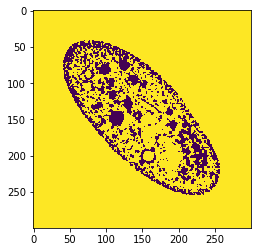

In [5]:
mor.view()

In [6]:
mor.save('binarize.bmp')

In [7]:
mor.close(4)

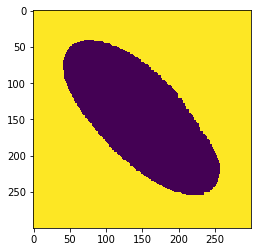

In [8]:
mor.view()

In [9]:
mor.save('closing.bmp')

In [10]:
mor.center()

In [11]:
print(mor.cg)

[146.94515525042908, 147.72288968637852]


In [12]:
mor.rect()

In [13]:
print(mor.rectangle)

[41, 256, 40, 253]


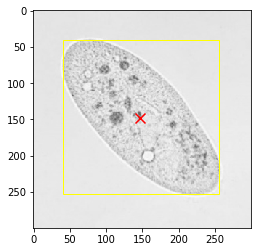

In [32]:
width = mor.rectangle[1] - mor.rectangle[0]
height = mor.rectangle[3] - mor.rectangle[2]
rect_edge = (mor.rectangle[0], mor.rectangle[2])
r = patches.Rectangle(xy=rect_edge, width=width, height=height, ec='#FFFF00', fill=False)
fig = plt.figure()
ax = fig.add_subplot()
plt.imshow(img)
ax.add_patch(r)
plt.scatter(mor.cg[0], mor.cg[1], marker='x', s=100, c='#FF0000')
plt.savefig('object.png')